Import

In [1]:
CUDA_LAUNCH_BLOCKING="1"

import os 
import warnings
warnings.simplefilter('ignore')

from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc

from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
import GPUtil
import copy

import wandb

%env "WANDB_NOTEBOOK_NAME" "grd-main"
wandb.init(project="influence-maximization", entity="mario-michelessa")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="grd-main"


wandb: Currently logged in as: mario-michelessa (use `wandb login --relogin` to force relogin)


Parameters

In [2]:
beta = 1                                        #Parameter of greedy optimizer, default 1
sample_size = 10                                #Parameter of greedy optimizer, default 10
eps = 0.2                                       #Parameter of greedy optimizer, default 0.1
k = 10                                          #Parameter of greedy optimizer, default 5

num_epochs = 10         
batch_size = 1
learning_rate = 5e-4

num_layers = 2
activation = 'relu'
#intermediate_size = 100
hidden_sizes = [150]


def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .02)

N_INFLUENCERS = 500
N_TARGETS = 500
N_FEATURES = 100
N_INSTANCES = 10 
N_TRAIN = int(0.8 * N_INSTANCES)
instance_path = "instances_weibo/embeddings/"

q1, q2, q3 = 0.2, 0.5, 0.8 #quantiles for ground_truth probabilities
low_p, med_p, high_p = 0.2, 0.5, 1 #buckets for ground_truth probabilities


wandb.config = {
    #instances parameters
    "N_INFLUENCERS": N_INFLUENCERS,
    "N_TARGETS": N_TARGETS,
    "N_FEATURES":N_FEATURES,
    "N_INSTANCES":N_INSTANCES,
    "instance_path" : instance_path,
    
    #labels parameters
    "(q1, q2, q3)" : (q1, q2, q3),
    '(low_p, med_p, high_p)' : (low_p, med_p, high_p),

    #greedy parameters
    "beta" : beta,               
    "sample_size" : sample_size,      
    "eps" : eps,              
    "k" : k,             

    #ML parameters
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "num_layers" : num_layers,
    "activation" : activation,
    "hidden_sizes" : hidden_sizes, }

Device

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



##### Instances definition

In [4]:

def transform_Y(Y, q1,q2,q3,low_p,med_p,high_p) : 
    Yc = np.copy(Y)
    #return np.minimum(100 * Y_train, np.ones((N_TRAIN, N_INFLUENCERS, N_TARGETS)))
    t1 = np.quantile(Y[Y>0], q1) # weak probability
    t2 = np.quantile(Y[Y>0], q2) # average medium probability
    t3 = np.quantile(Y[Y>0], q3) # high probability
    Y[Yc>t1] = low_p
    Y[Yc>t2] = med_p
    Y[Yc>t3] = high_p
    return Y  

@jit
def create_train_test(train_id,q1,q2,q3,low_p,med_p,high_p):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))

    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(instance_path + f"{instance}.npz")['arr_0']
        if instance in train_id :
            X_train[c_train] = XY[:,:,:-1]
            Y_train[c_train] = XY[:,:,-1]
            c_train += 1
        else : 
            X_test[c_test] = XY[:,:,:-1]
            Y_test[c_test] = XY[:,:,-1]
            c_test += 1
    
    #Cheating line
    #X_train[:,:,:,9] = Y_train * 2
    
    Y_train = transform_Y(Y_train,q1,q2,q3,low_p,med_p,high_p)
    Y_test = transform_Y(Y_test,q1,q2,q3,low_p,med_p,high_p)

    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    
    # test on random dense labels
    #Y_train = torch.bernoulli(torch.zeros(Y_train.size()),0.1)
    #Y_test = torch.bernoulli(torch.zeros(Y_test.size()),0.1)
    
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test



Definition of dataset

Text(0.5, 1.0, 'Histogram of the ground truth probabilities')

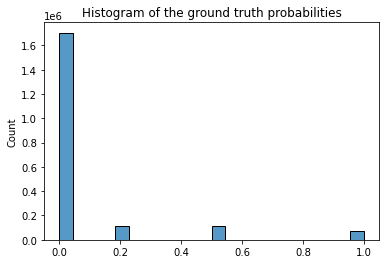

In [5]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
X_train, Y_train, X_test, Y_test = create_train_test(train_id,q1,q2,q3,low_p,med_p,high_p)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 

sns.histplot(Y_train.flatten(),)
plt.title("Histogram of the ground truth probabilities")

In [6]:
def print_training(loss, train, test, title = "") : 

    fig, ax = plt.subplots(1,2, figsize = (10,5))
    plt.suptitle(title)
    ax[0].plot(loss)
    ax[0].set_title('Learning curve')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')

    ax[1].plot(train, label="train_scores")
    ax[1].plot(test, label="test_scores")
    ax[1].set_title('Quality')
    ax[1].set_ylabel('influence')
    ax[1].set_xlabel('epoch')
    ax[1].legend()
    plt.show()
    

### Decision focused

Evaluation function

In [7]:
def eval_grd(net, X, Y):
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([    set_func(   greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])

    return result

Training

In [8]:
train_scores_df = []
test_scores_df  = []
loss_df = []

net_df = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout=0.5)
net_df.apply(init_weights)
net_df = net_df.to(device)
#net = net.half()
net_df.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=100, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=1, bias=True)
  (3): Hardtanh(min_val=0, max_val=1.0)
  (4): Dropout(p=0.5, inplace=False)
)>

epoch | loss | train_score | test_score 
0 | -302.29443359375 | 310.49565505981445 | 292.8267517089844
1 | -300.2975769042969 | 302.05914306640625 | 292.4745178222656
2 | -304.3345642089844 | 308.9436492919922 | 279.55621337890625
3 | -304.39593505859375 | 307.6527633666992 | 298.034912109375
4 | -309.09259033203125 | 305.6381950378418 | 297.16810607910156
5 | -298.6356506347656 | 302.89978790283203 | 295.7073974609375
6 | -306.92034912109375 | 303.6987190246582 | 295.2900085449219
7 | -305.3788757324219 | 305.1219787597656 | 289.6935272216797
8 | -306.60321044921875 | 304.8419990539551 | 293.6804504394531
9 | -309.09259033203125 | 306.1462631225586 | 275.850341796875
10 | -308.68731689453125 | 303.7562141418457 | 288.00144958496094
11 | -305.90667724609375 | 307.4146156311035 | 275.7472229003906
12 | -302.73382568359375 | 307.54897689819336 | 296.72572326660156
13 | -302.2306823730469 | 307.7074737548828 | 295.43035888671875
14 | -302.67218017578125 | 305.9671630859375 | 300.829681396

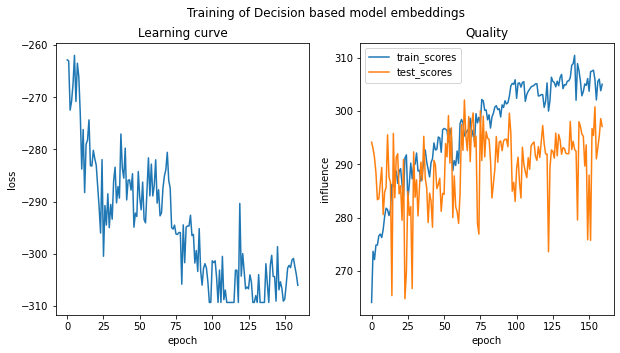

In [34]:

print("epoch | loss | train_score | test_score ")

optimizer = torch.optim.Adam(net_df.parameters(), lr = learning_rate)
marginal_vec_pred = partial(marginal_vec, w = w)

for epoch in range(20):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, )
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            
            true_set_func = partial(set_func, P = P, w = w)
            pred = net_df(X).view_as(P)                
            fn = GreedyOptimizer.apply
            loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta)
            del(X)
            del(P)
        
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_score = eval_grd(net_df, X_train, Y_train)
    test_score  = eval_grd(net_df, X_test, Y_test)
    loss_df.append(loss.item())
    wandb.log({"loss_df": loss})
    wandb.log({"train_score_df": train_score})
    wandb.log({"test_score_df": test_score})

    
    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores_df.append(train_score)
    test_scores_df.append(test_score)
    
print_training(loss_df, train_scores_df, test_scores_df, "Training of Decision based model embeddings")


Comparison with greedy algorithm applied to the ground-truth

In [35]:
def compare_grd(net,X,Y) : 
    pred = eval_grd(net, X,Y)
    
    X, Y = X.to(device), Y.to(device)
    th = np.mean([set_func(greedy(k, Y[i,:,:],w)[1],Y[i, :, :], w) for i in range(X.shape[0])])
    del(X)
    del(Y)
    print(f"The model predicts maximum influence {pred}")
    print(f"The theoretical maximum influence is {th}")
    
print("Decision_based on train dataset : ")
compare_grd(net_df, X_train, Y_train)

print("\n Decision_based on test dataset : ")
compare_grd(net_df, X_test, Y_test)

Decision_based on train dataset : 
The model predicts maximum influence 304.7580986022949
The theoretical maximum influence is 379.8334312438965

 Decision_based on test dataset : 
The model predicts maximum influence 292.6918487548828
The theoretical maximum influence is 376.595703125


### 2 Stage

In [11]:

train_scores_2s = []
test_scores_2s  = []
loss_2s = []

net_2s = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout=0.5)
net_2s.apply(init_weights)
net_2s = net_2s.to(device)

epoch | loss | train_score | test_score 
0 | 0.0419917106628418 | 351.7231025695801 | 325.22320556640625
1 | 0.04221896082162857 | 349.68681716918945 | 322.3417053222656
2 | 0.04179602488875389 | 350.74767303466797 | 324.0892639160156
3 | 0.04189731180667877 | 351.73857498168945 | 323.3811950683594
4 | 0.041626736521720886 | 350.8691940307617 | 319.9834289550781
5 | 0.041499413549900055 | 351.79570388793945 | 324.1024932861328
6 | 0.04180915653705597 | 350.0364112854004 | 323.11314392089844
7 | 0.04164331406354904 | 351.472957611084 | 319.68896484375
8 | 0.041623178869485855 | 351.4922752380371 | 322.59185791015625
9 | 0.04158473014831543 | 352.6465301513672 | 318.7555694580078


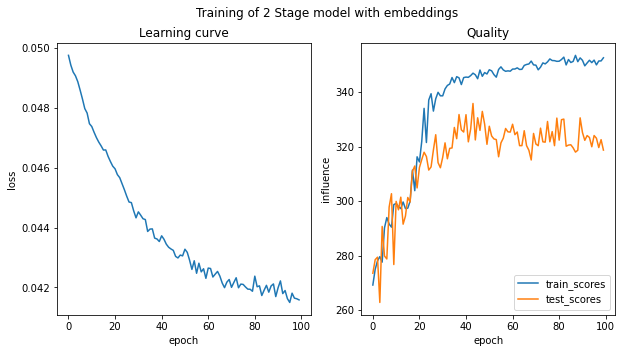

In [28]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net_2s.parameters(), lr = learning_rate)

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, ) #shuffle=True 
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net_2s(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_score = eval_grd(net_2s, X_train, Y_train)
    test_score  = eval_grd(net_2s, X_test, Y_test)
    print(f"{epoch} | {loss} | {train_score} | {test_score}")   

    wandb.log({"loss_2s": loss})
    wandb.log({"train_score_2s": train_score})
    wandb.log({"test_score_2s": test_score})

    train_scores_2s.append(train_score)
    test_scores_2s.append(test_score)     
    loss_2s.append(loss.item())

print_training(loss_2s, train_scores_2s, test_scores_2s,"Training of 2 Stage model with embeddings")


In [18]:
print("2-stage on train dataset : ")
compare_grd(net_2s, X_train, Y_train)

print("\n 2-stage on test dataset : ")
compare_grd(net_2s, X_test, Y_test)

2-stage on train dataset : 
The model predicts maximum influence 346.0107612609863
The theoretical maximum influence is 379.8334312438965

 2-stage on test dataset : 
The model predicts maximum influence 321.44366455078125
The theoretical maximum influence is 376.595703125


### Random

Influence when the seeds are randomly selected

In [19]:
    
def eval_rnd(X, Y):
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

rd_score_xtrain = np.mean([eval_rnd(X_train, Y_train) for _ in range(100)])
rd_score_xtest = np.mean([eval_rnd(X_test, Y_test) for _ in range(100)])
print(f"Average random score X_train : {rd_score_xtrain}")
print(f"Average random score X_test : {rd_score_xtest}")

wandb.log({"rd_score_xtrain" : rd_score_xtrain})
wandb.log({"rd_score_xtest" : rd_score_xtest})

Average random score X_train : 272.2828610992432
Average random score X_test : 272.03650535583495


### Hyperparameter tuning

Sweep definition

In [27]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep-df architecture 3 layers",

  "method" : "bayes",
  "metric":{
    "name": "test_score",
    "goal": "maximize",},

  "parameters" : {
    "layer1_size" : {"min" : 75, "max" : 200},
    "layer2_size" : {"min" : 75, "max" : 200} 
    }
  }

sweep_df = wandb.sweep(sweep_config)


Create sweep with ID: zqs8lp65
Sweep URL: https://wandb.ai/mario-michelessa/uncategorized/sweeps/zqs8lp65


In [28]:
def train_df():
  with wandb.init(project="influence-maximization", entity="mario-michelessa") as run:
    config = wandb.config

    net_df = make_fc(N_FEATURES, 3, activation, [config["layer1_size"],config["layer2_size"]], dropout=0.15)
    net_df.apply(init_weights)
    net_df = net_df.to(device)
    #net = net.half()
    optimizer = torch.optim.Adam(net_df.parameters(), lr = 5e-4, betas = (0.8, 0.999))
    marginal_vec_pred = partial(marginal_vec, w = w)

    for epoch in range(20):
      
      data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, )
      for X_batch, P_batch in data_loader:
          loss = 0 
          for X, P in zip(X_batch, P_batch):
              X = X.to(device)
              P = P.to(device)
              true_set_func = partial(set_func, P = P, w = w)
              pred = net_df(X).view_as(P)                
              fn = GreedyOptimizer.apply
              loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k, 0.2, sample_size, beta)
          
          loss = loss / 1
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      
      train_score = eval_grd(net_df, X_train, Y_train)
      test_score  = eval_grd(net_df, X_test, Y_test)

      wandb.log({"loss": loss})
      wandb.log({"train_score": train_score})
      wandb.log({"test_score": test_score})

count = 20 # number of runs to execute
wandb.agent(sweep_df, function=train_df, count=count)


wandb: Agent Starting Run: lstve1xp with config:
wandb: 	layer1_size: 126
wandb: 	layer2_size: 111
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,▆▄▃▁▂▁▁▁▁▂▂▂▂▂▃▂█▃▂▂
test_score,▆▇▇▆█▂▅▇▇▁▅▅▆▅▅▁▂▅▅▅
train_score,▁▁▃▇▆▇▇▇██▇▇▇▇▇▇▇█▇▇
loss,-352.81332
test_score,298.10503
train_score,335.10834


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jrw39rsx with config:
wandb: 	layer1_size: 186
wandb: 	layer2_size: 116
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▆▅▅▃▂▁▁▂▁▁▃▂▁▁▁▃▁▂▁
test_score,▃▅▄▇▇█▅▅▁▃▄▄▃▅▄▄▃▅▃▄
train_score,▁▃▃▅▇▆▆█▆▇█▇█▇▇▇▇███
loss,-370.54498
test_score,307.67816
train_score,343.74974


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kbs7jq9v with config:
wandb: 	layer1_size: 185
wandb: 	layer2_size: 116
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,▄▃▃▃▂▂▂▁▂▇███████▇██
test_score,█▇███████▁▁▁▁▁▁▁▁▁▁▁
train_score,▇████████▁▁▁▁▁▁▁▁▁▁▁
loss,-267.15033
test_score,37.54913
train_score,37.40527


wandb: Agent Starting Run: 7pel330z with config:
wandb: 	layer1_size: 85
wandb: 	layer2_size: 81
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▆▃▃▂▂▅▂▁▂▂▂▁▁▁▂▁▁▂▁
test_score,▃▁▅▇▁▃▃▅▃▂▄▅▄▆▃█▃▆▅▅
train_score,▁▂▃▂▅▇▆▇▇▇▆█▇███▇█▇▇
loss,-366.71979
test_score,301.95854
train_score,335.44761


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6j7m3jc5 with config:
wandb: 	layer1_size: 139
wandb: 	layer2_size: 171
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▇▄▅▄▃▁▁▃▃▁▂▁▁▃▁▁▃▁▁
test_score,▇▅▅▅▁▆█▆▅▃▄▇▇▇▆▆▆▆▄█
train_score,▁▃▃▃▅▇▆▆▆▆▇▇█▇▆█▇█▇▇
loss,-369.14923
test_score,306.47015
train_score,336.91282


wandb: Agent Starting Run: qlu5aecm with config:
wandb: 	layer1_size: 106
wandb: 	layer2_size: 187
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,▆██▆▅▅▂▄▂▂▂▂▂▂▂▂▁▁▁▁
test_score,▄▆▅▁▇▄▇▄▇▅▇▇█▆▇▆▇███
train_score,▁▃▄▅▅▆▆▇▇▇▇▇███▇███▇
loss,-368.92041
test_score,304.95781
train_score,337.73606


wandb: Agent Starting Run: oicy0az1 with config:
wandb: 	layer1_size: 193
wandb: 	layer2_size: 77
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▃█▃▃▃▃▁▂▂▃▃▁▂▁▁▁▁▁▂
test_score,█▆▄▁▅▆▅▅▆▅█▄▆▅▅▆▆▅▆▆
train_score,▂▃▁▄▄▅▅▆▇▅▆▆▇▇▇▇██▇▇
loss,-364.96515
test_score,303.96527
train_score,341.07964


wandb: Agent Starting Run: 96b05lhf with config:
wandb: 	layer1_size: 83
wandb: 	layer2_size: 88
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,▇██▅▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁
test_score,▂▅▆▇▂▃▄▅▂▆█▇▇▂█▆▅▂▁▂
train_score,▁▁▁▄▅▄▅▅▆▆▇▇█▇▇█▇█▇█
loss,-371.62778
test_score,300.15712
train_score,342.57928


wandb: Agent Starting Run: rb77ws4a with config:
wandb: 	layer1_size: 79
wandb: 	layer2_size: 187
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,██▆▄▄▂▁▂▂▂▃▁▁▂▁▁▁▁▁▁
test_score,▄▆▁▅▇▄▇▅▄█▄▅▄▆▆▆▄▆▆▅
train_score,▃▁▄▅▆▆█▇▇██▇████████
loss,-370.06793
test_score,303.13275
train_score,340.19923


wandb: Agent Starting Run: nsyomb8h with config:
wandb: 	layer1_size: 158
wandb: 	layer2_size: 157
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▇▁▁▁▃▁▁▂▂▁▁▁▁▁▁▁▁▁▅
test_score,▃▇▅▅▆▄█▆▅▇█▅▄▅▅▃▅▅▅▁
train_score,▃▁▆▇▆▅▆▆▅▆▆▆▆▇▇▇█▇▇▄
loss,-327.71063
test_score,294.08253
train_score,328.0527


wandb: Agent Starting Run: sndyhdf3 with config:
wandb: 	layer1_size: 167
wandb: 	layer2_size: 99
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,▇█▅▄▆▅▄▂▂▁▂▂▃▁▁▁▁▂▂▁
test_score,█▄▁▃▆▄▆▄▄▅▄▄▅▅▅▅▄▄▄▅
train_score,▁▂▃▅▄▄▆▆▆██▇▇▇█▇█▇▇█
loss,-374.93494
test_score,304.983
train_score,341.56347


wandb: Agent Starting Run: 3myzjy5d with config:
wandb: 	layer1_size: 184
wandb: 	layer2_size: 101
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,██▅▄▄▂▂▂▂▁▁▁▃▁▂▂▁▁▁▁
test_score,▃▂▁▂▂▁▂▅█▆█▆▆▅▆▆▇▇▆▆
train_score,▁▃▃▄▆▆▇▇▇▇█▇▇█████▇█
loss,-369.84839
test_score,309.40123
train_score,341.68999


wandb: Agent Starting Run: ba0nyv5x with config:
wandb: 	layer1_size: 139
wandb: 	layer2_size: 79
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


loss,██▆▂▁▃▁▁▁▁▂▁▁▁▁▂▂▂▃▂
test_score,▅▅▅▅▃▃▆▄▄▅▇▆█▄▅▄▆▃▁▄
train_score,▁▂▆▇▇▇█▇██▇██▇█▇█▇██
loss,-358.42548
test_score,299.98112
train_score,338.88556


wandb: Agent Starting Run: 2fymjjop with config:
wandb: 	layer1_size: 123
wandb: 	layer2_size: 144
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▅▄▁▃▃▃▂▁▂▅▁▂▂▂▂▃▃▁▂
test_score,▃▁█▆▅▃▇▇▇▃▄██▇▇▇▆▅█▇
train_score,▁▃▆▇▆▆█▇▆▇▇█▇█▇███▇█
loss,-365.47238
test_score,306.33116
train_score,340.69024


wandb: Agent Starting Run: 5qulby6g with config:
wandb: 	layer1_size: 81
wandb: 	layer2_size: 125
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▇▃▃▄▃▃▃▃▁▁▁▁▁▁▁▁▁▂▁
test_score,▆▇▂▅▃▁▃▅▂▄▄▄▅▃▅▅▄█▃▆
train_score,▁▁▃▅▄▄▅▅▆▇▇██▇████▆▆
loss,-368.78903
test_score,308.4265
train_score,335.8558


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zhss0auo with config:
wandb: 	layer1_size: 125
wandb: 	layer2_size: 80
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▅▅▅▃▂▁▂▂▁▂▃▁▂▁▃▂▂▁▂
test_score,▁▇▃▇▅█▆▄▇▆▅▅▇▆▇▆▅▆▆▇
train_score,▁▃▄▅▇▆▇▇▆█▇█▇▇▇▇▇███
loss,-362.88467
test_score,306.58633
train_score,342.69314


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d92opbu5 with config:
wandb: 	layer1_size: 89
wandb: 	layer2_size: 165
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▄▅▅▆▃▁▁▁▁▁▁▂▂▁▁▂▁▁▁
test_score,▅▆▁▄▅▄▅▅▄█▄▇▆▆▆▇▆▆▅▆
train_score,▁▁▄▆▅▆▇▇▆█▇█████████
loss,-370.67502
test_score,300.96692
train_score,339.33269


wandb: Agent Starting Run: ekr9gikw with config:
wandb: 	layer1_size: 178
wandb: 	layer2_size: 175
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,▆▆▃▄█▅▅▃▃▅▁▁▂▃▂▂▁▁▂▃
test_score,▄▅▄▆▆▃▁▄▃▇▅▆▅▅▇▅█▆▄▆
train_score,▁▁▅▅▄▆▅▇▇▇█▇▇███▇██▇
loss,-352.66074
test_score,303.16193
train_score,338.43164


wandb: Agent Starting Run: mms8dzs6 with config:
wandb: 	layer1_size: 146
wandb: 	layer2_size: 124
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▄▃▃▃▃▁▁▁▂▁▁▁▁▁▁▁▂▁▁
test_score,▁▃▄▂▄▃▄▃▄▂▄▂▂▄▄▆█▅▆▆
train_score,▁▃▃▆▅▇███▇██████▇▇██
loss,-372.44189
test_score,314.74855
train_score,339.1793


wandb: Agent Starting Run: 51aumtwa with config:
wandb: 	layer1_size: 173
wandb: 	layer2_size: 167
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


loss,█▆▅▂▇▅▃▃▃▃▃▁▁▂▁▂▁▁▁▁
test_score,▃▃▂▁▃▁▁█▄▆▆▄▄▄▄▂▄▇▆█
train_score,▁▃▂▄▅▄▄▃▅▄▆▇▇██▇▇█▇▇
loss,-366.92206
test_score,320.02779
train_score,336.93718


https://wandb.ai/mario-michelessa/uncategorized/sweeps/093v3sok?workspace=user-mario-michelessa 

    small batch_size gives better results

https://wandb.ai/mario-michelessa/uncategorized/sweeps/2yui1w63?workspace=user-mario-michelessa

    3 layers is not useful 

https://wandb.ai/mario-michelessa/uncategorized/sweeps/0c8bqnd8?workspace=user-mario-michelessa

    learning_rate > 2e-3 often causes collapsing

https://wandb.ai/mario-michelessa/uncategorized/sweeps/nl6o80go?workspace=user-mario-michelessa

    influence of architecture and small learning rate

https://wandb.ai/mario-michelessa/uncategorized/sweeps/e2f0obic?workspace=user-mario-michelessa

    influence of dropout on testscore : p=0.15 gives smallest variance and best results

Sweep 2 stage

In [9]:
sweep_config = {
  "program" : "grd-main",
  "name" : "sweep-2s",

  "method" : "bayes",
  "metric":{
    "name": "loss",
    "goal": "minimize",},

  "parameters" : {
    "epochs" :            { "values" : [10] },
    "learning_rate" :     { "min": 0.00005, "max": 0.01 },
    "num_layers" :        {"values" : [3] },
    "layer1_size" :       {"values" : [50,100,150,200]}, 
    "layer2_size" :       {"values" : [50,100,150,200]}, 
    "dropout" : {"min" : 0.01, "max" : 0.5},
    }

  }

sweep_2s = wandb.sweep(sweep_config)

Create sweep with ID: iqhi3l2g
Sweep URL: https://wandb.ai/mario-michelessa/uncategorized/sweeps/iqhi3l2g


In [25]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)

def train_2s():
  with wandb.init(project="influence-maximization", entity="mario-michelessa") as run:
    config = wandb.config

    #X_train, Y_train, X_test, Y_test = create_train_test(train_id,config["q1"],config["q2"],config["q3"],config["low_p"],config["med_p"],config["high_p"])
    #dataset = torch.utils.data.TensorDataset(X_train, Y_train) 

    net_2s = make_fc(N_FEATURES, num_layers, activation, [config["layer1_size"],config["layer2_size"]], config["dropout"])
    net_2s.apply(init_weights)
    net_2s = net_2s.to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net_2s.parameters(), lr = learning_rate, betas=(0.8, 0.999))

    for epoch in range(num_epochs):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, ) #shuffle=True 
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X, P = X.to(device), P.to(device)
                pred = net_2s(X).view_as(P)
                loss += loss_fn(pred, P)
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_score = eval_grd(net_2s, X_train, Y_train)
        test_score  = eval_grd(net_2s, X_test, Y_test)

        wandb.log({"loss": loss})
        wandb.log({"train_score": train_score})
        wandb.log({"test_score": test_score})

count = 15 # number of runs to execute
wandb.agent(sweep_2s, function=train_2s, count=count,)


NameError: name 'sweep_2s' is not defined

https://wandb.ai/mario-michelessa/uncategorized/sweeps/qqcxc892?workspace=user-mario-michelessa

    study of greedy parameters
    best performing models have : batch_size < 16 + 2 layers + high_p > 0.95 + learning_rate > 2e-3

https://wandb.ai/mario-michelessa/uncategorized/sweeps/iqhi3l2g?workspace=user-mario-michelessa

    A momentum > 0.96 is not beneficial
    Layers < 100 are too small
    Layer 2 size is more important than layer 1 size

### Plots


#### Curves week1

(-0.08, 0.0)

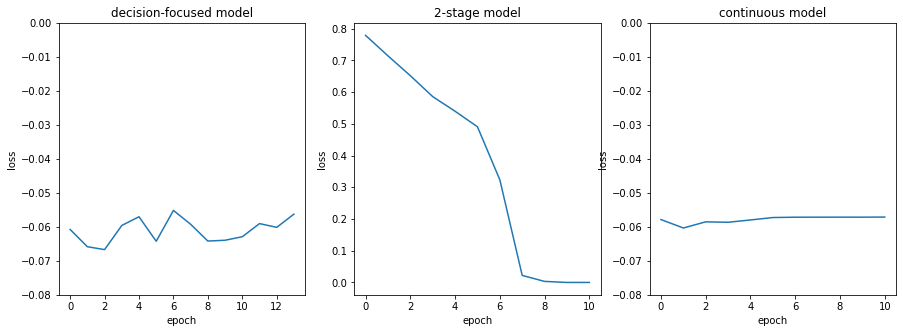

In [14]:
loss_decision = [-0.06076928973197937,-0.06584206968545914,-0.06670479476451874,-0.05958820879459381,-0.0570240244269371,-0.06424318253993988,-0.05516466125845909,-0.05924143642187118,-0.06418315321207047,-0.06394138187170029,-0.06290893256664276,-0.05904095247387886,-0.06015191227197647,-0.05625718086957931,]
loss_2_stage = [0.7789968252182007, 0.7144742012023926, 0.6519206762313843, 0.5859464406967163 ,0.5397264361381531 ,0.4908316731452942 ,0.32362160086631775, 0.022119728848338127, 0.00329726655036211, 9.616058378014714e-06,  1.4370152712217532e-06]
loss_CNT = [-0.057850807905197144,-0.06033829599618912,-0.058524295687675476,-0.05864942446351051,-0.057970765978097916,-0.05725716054439545,-0.05716206878423691,-0.0571533665060997,-0.057145409286022186,-0.05715050548315048,-0.05711754783987999,]

fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(loss_decision)
ax[0].set_title("decision-focused model")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_ylim(-0.08,0)

ax[1].plot(loss_2_stage)
ax[1].set_title("2-stage model")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")

ax[2].plot(loss_CNT)
ax[2].set_title("continuous model")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("loss")
ax[2].set_ylim(-0.08,0)

Text(0.5, 0, 'epoch')

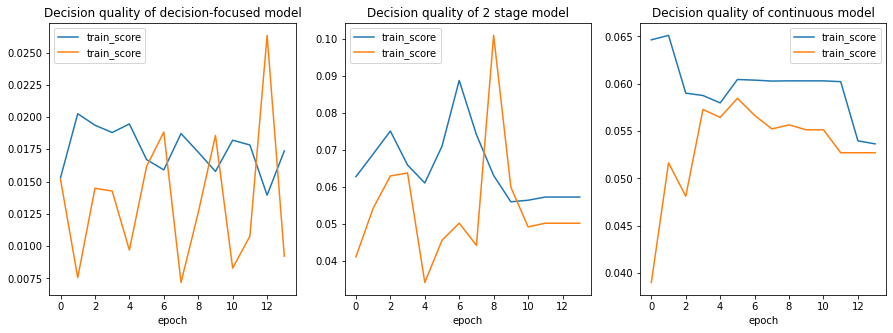

In [15]:
quality_decision_based_train=[0.015288348495960235,0.020257513225078582 ,0.01936897709965706  ,0.018799322098493575 ,.019463644921779634  ,0.016700024902820586 ,0.01590406075119972  ,0.01871654763817787  ,0.017278300225734712 ,0.015782848000526428 ,0.01820402070879936  ,0.017835138738155364 ,0.013945347815752029 ,0.01737329438328743  ]
quality_decision_based_test  = [0.015173667669296264,0.007551929354667664,0.014478504657745361,0.014267870783805847,0.009686842560768127,0.01617351770401001,0.01883455514907837,0.007182687520980835,0.012591168284416199,0.018572977185249327,0.008294036984443665,0.010770317912101746,0.02632948160171509,0.009215238690376281,]

quality_2_stage_train = [0.06274317726492881, 0.06885293275117874, 0.0750866748392582, 0.06588671803474426, 0.06102966964244842, 0.07097437083721161, 0.08876516669988632, 0.0741001047194004, 0.06304563134908676, 0.05594222992658615, 0.056365196406841275, 0.05722642466425896, 0.05722642466425896, 0.05722642466425896]
quality_2_stage_test = [0.04106912612915039,0.054186728596687314,0.06293168067932128,0.0637294352054596,0.034126061201095584,0.045535266399383545,0.050166568160057066,0.044150781631469724,0.1009661465883255,0.05989144742488861,0.04914851486682892,0.050147178769111636, 0.050147178769111636, 0.050147178769111636]

quality_CNT_train = [0.06463120132684708,0.06510359048843384  ,0.058999452739953995, 0.05875115767121315  ,0.057967768609523775 ,0.06044074296951294  ,0.06037365570664406  ,0.0602763794362545   ,0.060297693312168124 ,0.060297693312168124 ,0.060297693312168124 ,0.0602118082344532   ,0.0539618082344532   ,0.05364147499203682   ]
quality_CNT_test = [0.039006182551383974,0.05163630247116089,0.048112612962722776,0.05727651119232178,0.05643411874771118,0.058458879590034485,0.05664604902267456,0.055219563841819766,0.0556481271982193,0.05512729585170746,0.05512729585170746,0.05270652174949646,0.05270652174949646,0.05270652174949646]


fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(quality_decision_based_train, label = "train_score")
ax[0].plot(quality_decision_based_test, label = "train_score")
ax[0].set_title("Decision quality of decision-focused model")
ax[0].legend()
ax[0].set_xlabel("epoch")

ax[1].plot(quality_2_stage_train, label = "train_score")
ax[1].plot(quality_2_stage_test, label = "train_score")
ax[1].set_title("Decision quality of 2 stage model")
ax[1].legend()
ax[1].set_xlabel("epoch")

ax[2].plot(quality_CNT_train, label = "train_score")
ax[2].plot(quality_CNT_test, label = "train_score")
ax[2].set_title("Decision quality of continuous model")
ax[2].legend()
ax[2].set_xlabel("epoch")


#### Printing features of one instance

IndexError: index 29 is out of bounds for dimension 3 with size 29

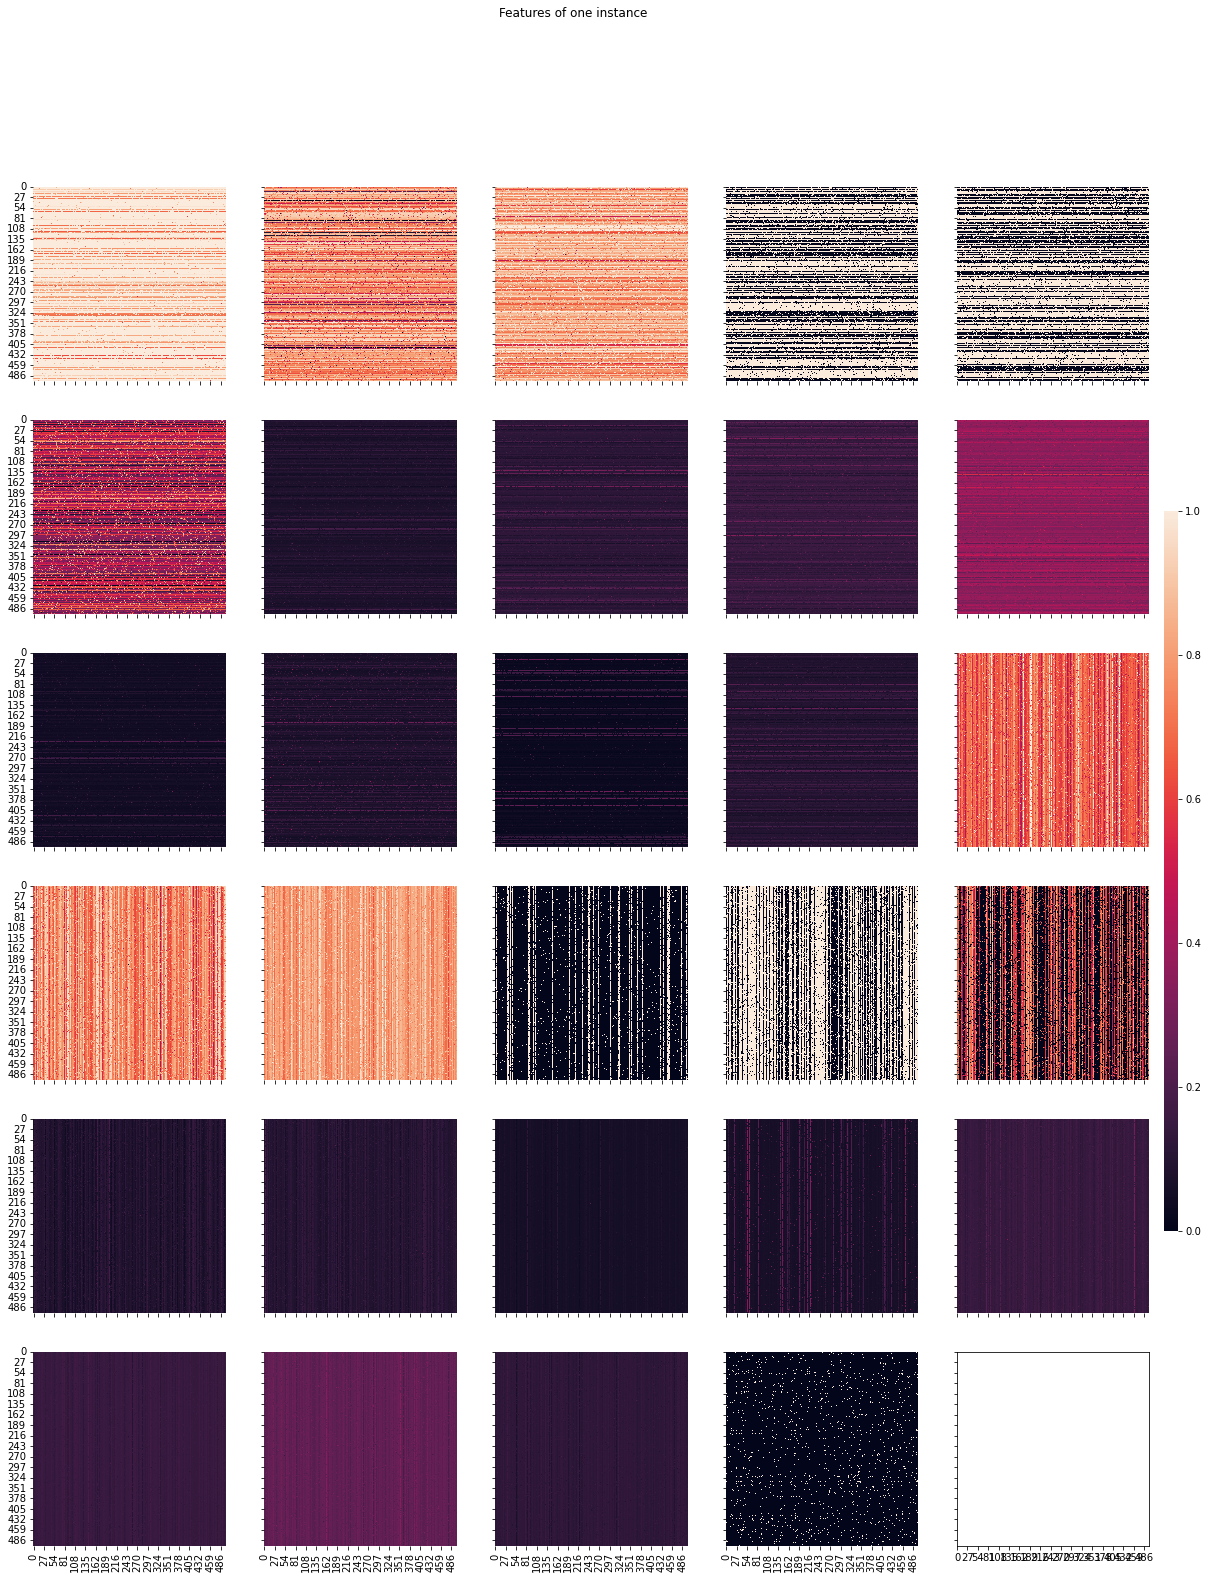

In [49]:
fig, axn = plt.subplots(6, 5, sharex=True, sharey=True, figsize = (20,25))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    if i > 28 : break
    sns.heatmap(X_train[1,:,:,i], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)



#### Plot of hidden layers weights

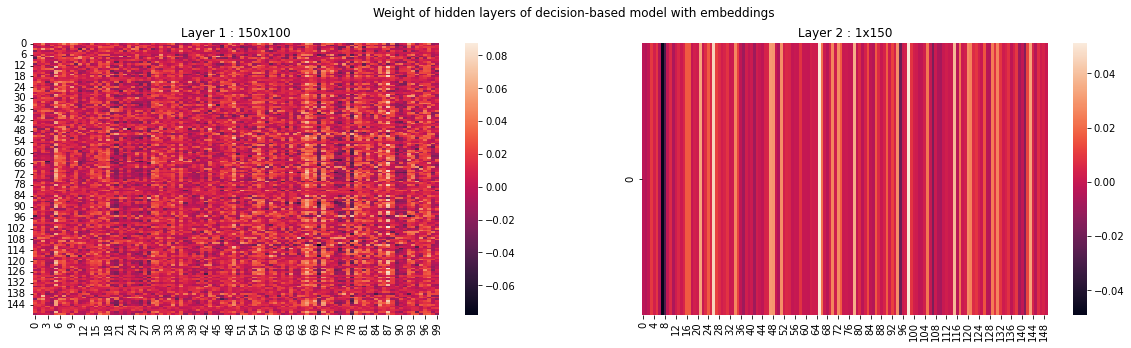

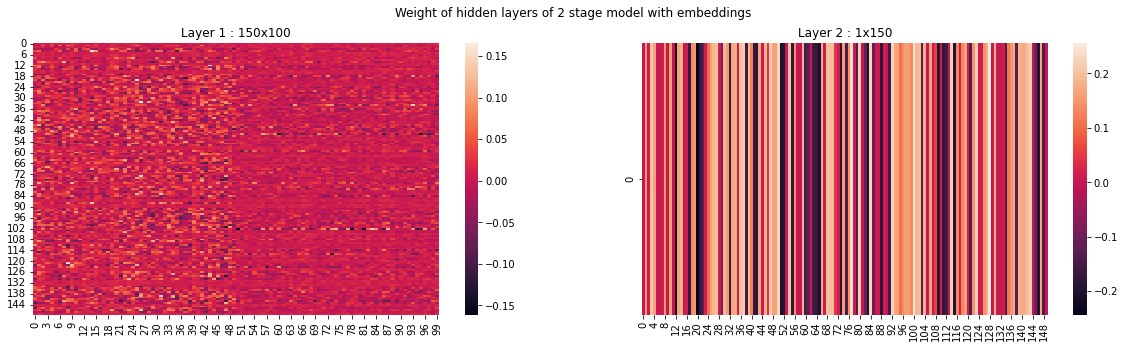

In [37]:
def print_hidden_layers(net, title) : 
    fig,ax = plt.subplots(1 , num_layers, figsize = (20,5))
    plt.suptitle(title)

    for i,ax in enumerate(ax.flat) :
        weights = net[2*i].weight.detach().cpu().numpy()
        sns.heatmap(weights, ax=ax)
        ax.set_title(f'Layer {i + 1} : {weights.shape[0]}x{weights.shape[1]}')
        
print_hidden_layers(net_df, 'Weight of hidden layers of decision-based model with embeddings')
print_hidden_layers(net_2s, 'Weight of hidden layers of 2 stage model with embeddings')

#### Comparison between output of model and labels

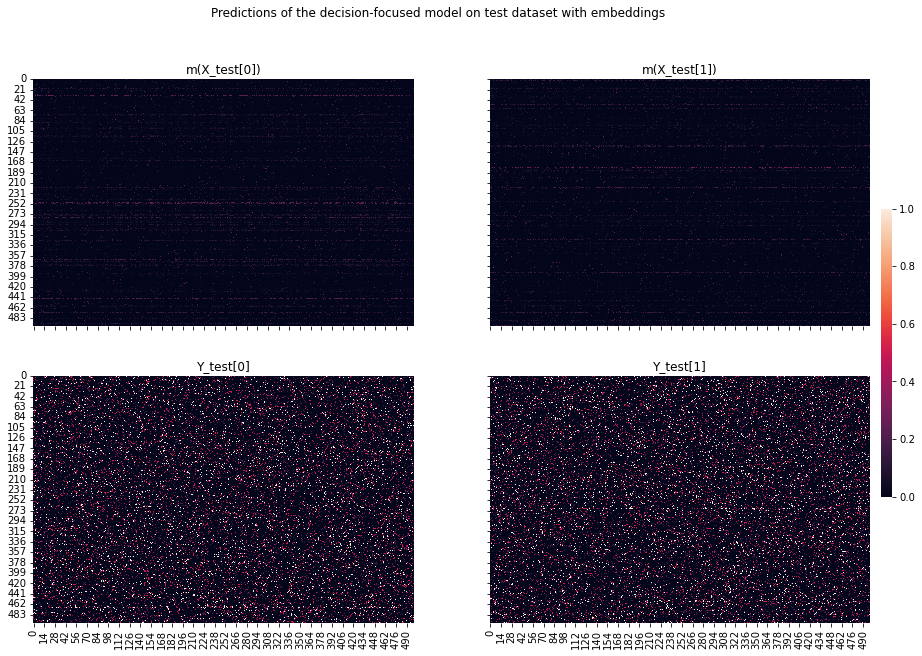

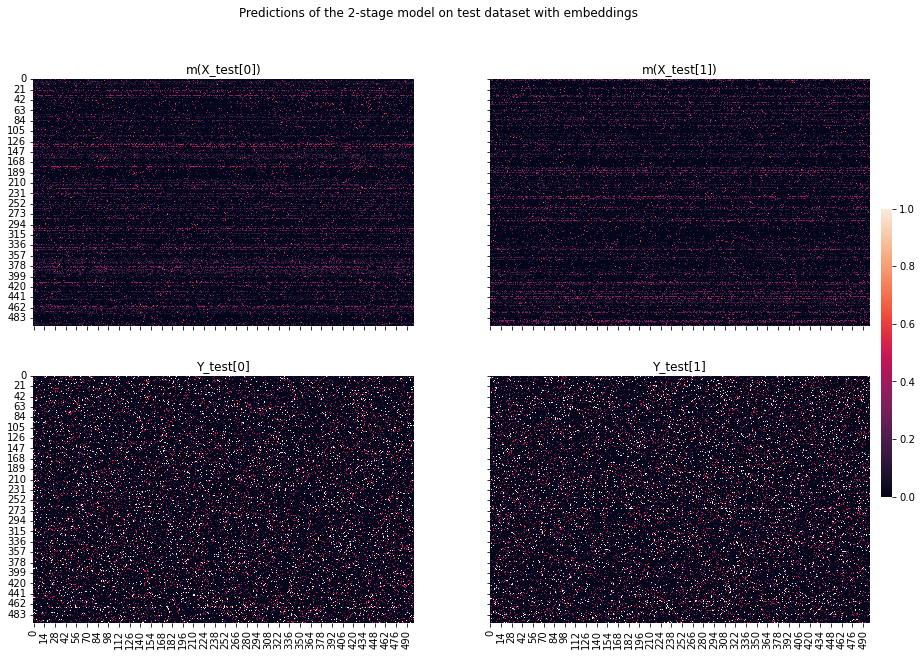

In [39]:
def print_output_test(net, title) :
    fig,ax = plt.subplots(2, 2, figsize = (15,10),sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .01, .4])
    #netcpu = copy.deepcopy(net).to('cpu')
    plt.suptitle(title)
    for i,ax in enumerate(ax.flat) :
        if i < 2 : 
            sns.heatmap(net(X_test[i].to(device)).view_as(Y_test[0]).detach().cpu(), 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0))
            ax.set_title(f'm(X_test[{i}])')
        else : 
            sns.heatmap(Y_test[i-2], 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0))
            ax.set_title(f'Y_test[{i-2}]')

print_output_test(net_df, "Predictions of the decision-focused model on test dataset with embeddings")
print_output_test(net_2s, "Predictions of the 2-stage model on test dataset with embeddings")

#### Curves cheating model

In [70]:
loss_df_cheat = [-616.76708984375, -626.2454833984375, -656.6033325195312, -686.2703857421875, -699.3722534179688, -714.6351318359375, -683.4835815429688, -698.6654052734375, -717.0424194335938, -686.1061401367188, -710.7937622070312, -719.3179931640625, -734.3993530273438, -734.3993530273438, -721.949951171875, -722.7680053710938, -718.9629516601562, -724.6202392578125, -733.5610961914062, -728.3310546875, -734.0625610351562, -725.25830078125, -734.3993530273438, -731.4889526367188, -728.6439208984375, -731.0556030273438, -722.762939453125, -731.1055908203125, -728.6141357421875, -734.3993530273438] 
train_df_cheat = [629.9470596313477, 638.5685501098633, 642.0366058349609, 703.2988510131836, 698.786247253418, 709.4888305664062, 699.473876953125, 712.2246627807617, 716.4704742431641, 711.5155563354492, 719.775032043457, 722.5051498413086, 721.8442840576172, 721.8442840576172, 721.8442840576172, 721.8442840576172, 723.5446319580078, 725.4313583374023, 726.6796112060547, 726.6796112060547, 726.4608688354492, 726.4608688354492, 727.2290420532227, 728.2420043945312, 729.2425994873047, 727.2290420532227, 726.692024230957, 726.551399230957, 728.2732467651367, 728.8333206176758] 
test_df_cheat = [605.38330078125, 607.0361328125, 607.0361328125, 596.6180419921875, 628.5375061035156, 613.8291931152344, 605.892333984375, 614.2778015136719, 634.3419799804688, 616.5736083984375, 602.6708679199219, 619.3488159179688, 637.6357116699219, 641.7950439453125, 646.4789123535156, 643.7948608398438, 654.0169677734375, 652.84521484375, 647.2266845703125, 647.2266845703125, 654.5975341796875, 651.2433471679688, 646.6016845703125, 640.8055419921875, 640.8055419921875, 645.3857116699219, 639.9603271484375, 632.5069580078125, 638.3273620605469, 638.2666625976562]

loss_2s_cheat = [0.07514822483062744, 0.07254979759454727, 0.06513979285955429, 0.048453375697135925, 0.02143559791147709, 0.0013291946379467845, 0.00014993258810136467, 0.0001558301883051172, 0.00013897819735575467, 0.00011833121970994398, 9.452990343561396e-05, 8.159576100297272e-05, 6.7353859776631e-05, 5.073147622169927e-05, 4.488118793233298e-05]
train_2s_cheat = [623.6631622314453, 650.1829223632812, 657.9133529663086, 640.093505859375, 645.1379776000977, 695.9493942260742, 730.6371917724609, 731.6124114990234, 731.9684829711914, 731.6785583496094, 731.6785583496094, 731.6785583496094, 731.2400131225586, 731.2400131225586, 731.2400131225586]
test_2s_cheat = [610.2027893066406, 605.4592895507812, 629.9775695800781, 626.3638000488281, 641.194091796875, 632.7218933105469, 638.4194641113281, 637.040283203125, 637.1872863769531, 636.5039672851562, 627.0595092773438, 627.0595092773438, 627.0595092773438, 628.5416259765625, 638.6458129882812]

loss_df = [-590.6621704101562, -613.7133178710938, -593.3753662109375, -590.0100708007812, -608.2012939453125, -617.9049682617188, -586.08349609375, -630.3292236328125, -608.1761474609375, -586.63818359375, -605.3233032226562, -586.8829956054688, -582.94921875, -611.841796875, -590.0680541992188, -607.3931884765625, -607.6980590820312, -619.517822265625, -605.1031494140625, -599.5083618164062, -604.5616455078125, -618.5628051757812, -595.2598876953125, -595.3056030273438, -616.2832641601562, -609.8016357421875, -616.5383911132812, -618.5928344726562, -602.7210693359375, -622.9998168945312]
train_df = [594.0173721313477, 604.7565155029297, 609.2598419189453, 611.4317092895508, 610.756721496582, 609.4155578613281, 603.27734375, 604.1050109863281, 604.8847732543945, 604.8847732543945, 604.3743515014648, 604.8847732543945, 605.7866897583008, 603.5101165771484, 604.7578964233398, 606.5402526855469, 609.9358825683594, 610.937614440918, 611.290397644043, 613.0837936401367, 613.6254577636719, 614.4277114868164, 616.3808364868164, 617.2204208374023, 609.2020263671875, 614.4277114868164, 614.5881271362305, 614.5881271362305, 612.9497680664062, 610.6737289428711]
test_df = [617.5375061035156, 609.1499633789062, 612.6041564941406, 613.0208435058594, 614.7374877929688, 607.9000244140625, 614.6986083984375, 620.3013610839844, 623.5235900878906, 623.5235900878906, 623.5235900878906, 623.5235900878906, 616.0361022949219, 622.2861022949219, 621.5083312988281, 621.5083312988281, 619.7124938964844, 614.7374877929688, 613.0208435058594, 614.5625, 613.0208435058594, 606.6291809082031, 613.0208435058594, 613.0208435058594, 606.6291809082031, 606.6291809082031, 605.6708374023438, 605.6708374023438, 612.7291870117188, 612.7291870117188]

loss_2s = [0.07531895488500595, 0.07615774124860764, 0.0761466771364212, 0.0752626582980156, 0.07564573734998703, 0.07590845972299576, 0.07560684531927109, 0.07585170865058899, 0.07609368115663528, 0.07599911838769913, 0.07597601413726807, 0.07644083350896835, 0.07595032453536987, 0.07539264112710953, 0.0747307538986206]
train_2s = [610.1749725341797, 603.9264755249023, 600.3566818237305, 602.0867004394531, 627.4701690673828, 632.5379791259766, 640.9370880126953, 639.4687728881836, 637.4927368164062, 639.205696105957, 641.1612243652344, 641.1612243652344, 642.7198028564453, 631.2514877319336, 627.8336181640625]
test_2s = [620.6798706054688, 622.652099609375, 615.7944946289062, 620.7250061035156, 630.4122314453125, 637.1191101074219, 639.4272155761719, 642.6702880859375, 639.6907348632812, 645.7737426757812, 640.662841796875, 640.662841796875, 652.22509765625, 656.0688781738281, 655.4230346679688]

Comparison between cheating models and normal models

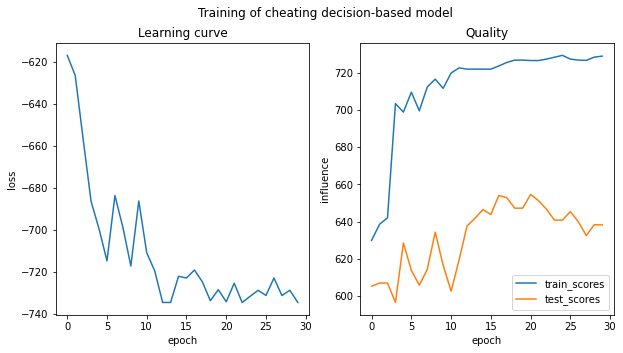

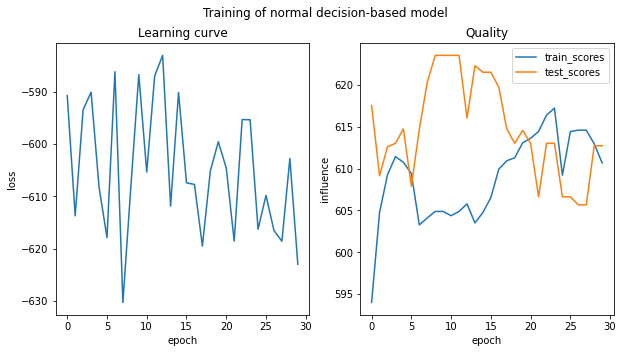

In [71]:
print_training(loss_df_cheat, train_df_cheat, test_df_cheat, "Training of cheating decision-based model")
print_training(loss_df, train_df, test_df, "Training of normal decision-based model")

Adding the topology of the graph

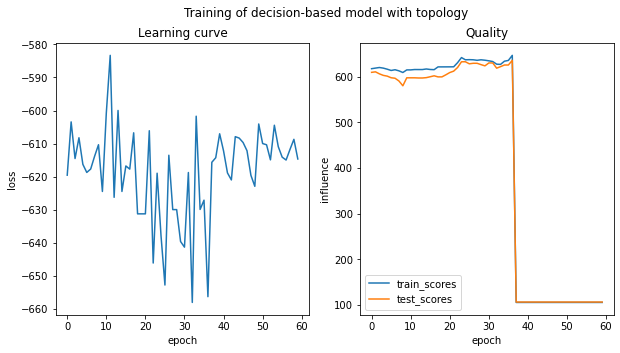

60


In [35]:

loss_df_topo = [-619.5857543945312, -603.4478759765625, -614.5478515625, -608.2476806640625, -616.3049926757812, -618.7550048828125, -617.7275390625, -613.8657836914062, -610.3626098632812, -624.5166625976562, -600.75830078125, -583.2958374023438, -626.2916259765625, -599.9833374023438, -624.5166625976562, -616.7916259765625, -617.7532958984375, -606.7527465820312, -631.2973022460938, -631.2973022460938, -631.2973022460938, -606.1243896484375, -646.1941528320312, -618.9900512695312, -637.9584350585938, -652.8555908203125, -613.5471801757812, -630.01025390625, -630.01025390625, -639.6707763671875, -641.3819580078125, -618.77880859375, -658.1292114257812, -601.7238159179688, -629.9630126953125, -627.1560668945312, -656.382568359375, -615.6832275390625, -614.3018188476562, -607.0485229492188, -612.2347412109375, -618.8964233398438, -621.024169921875, -607.9194946289062, -608.3514404296875, -609.6941528320312, -612.1798706054688, -619.6259765625, -622.9572143554688, -604.0802001953125, -610.0095825195312, -610.3702392578125, -614.9418334960938, -604.4588623046875, -610.9410400390625, -614.1242065429688, -615.000244140625, -611.7780151367188, -608.7266845703125, -614.6864013671875]
train_df_topo = [617.5399627685547, 618.8777694702148, 620.1529006958008, 618.7924041748047, 616.4651184082031, 613.6740798950195, 615.2547836303711, 612.8440399169922, 609.1955795288086, 614.9063873291016, 614.9063873291016, 615.7202453613281, 615.6787033081055, 615.6787033081055, 616.9194107055664, 615.8308639526367, 615.4168014526367, 621.4992523193359, 621.4992523193359, 621.5435333251953, 621.59130859375, 621.6975860595703, 630.6927795410156, 641.9276733398438, 637.0576858520508, 637.3375396728516, 637.0576858520508, 635.9438018798828, 637.0564041137695, 636.1268997192383, 634.7950973510742, 633.1996765136719, 627.4301223754883, 626.9901962280273, 633.9727172851562, 635.6409530639648, 646.7624893188477, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402, 105.68021202087402]
test_df_topo = [609.572265625, 610.6583862304688, 606.2625732421875, 602.9145202636719, 601.2694702148438, 597.7141418457031, 596.6627502441406, 590.62109375, 580.1087341308594, 597.5809936523438, 597.5809936523438, 597.5809936523438, 597.2101440429688, 597.2101440429688, 597.9559631347656, 599.9073486328125, 601.9698791503906, 599.6156616210938, 599.6156616210938, 604.1601257324219, 609.0989990234375, 612.1927490234375, 620.1656188964844, 632.69580078125, 632.7374877929688, 628.2555541992188, 629.397216796875, 629.397216796875, 626.4708251953125, 623.7520751953125, 630.1479187011719, 630.1479187011719, 618.6668090820312, 622.0751037597656, 625.6167907714844, 625.6167907714844, 635.8049926757812, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484, 106.58333587646484]

print_training(loss_df_topo, train_df_topo, test_df_topo, "Training of decision-based model with topology")


#### Curves 29 features

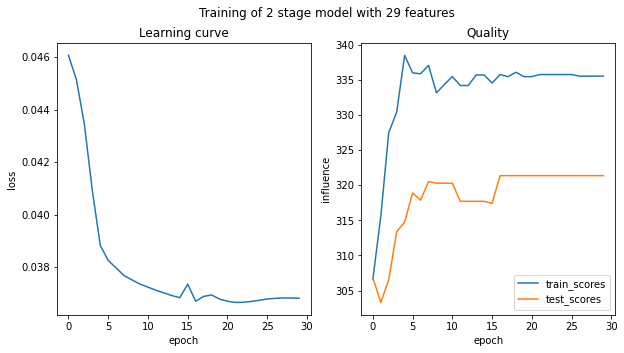

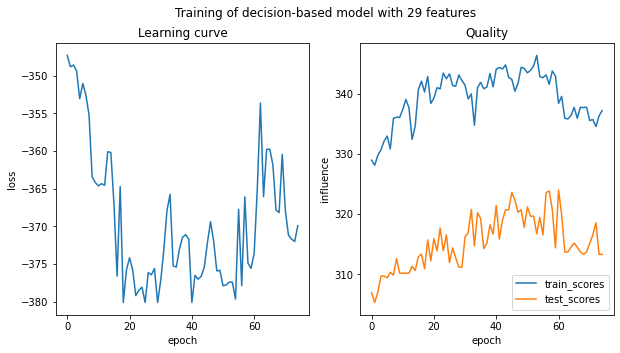

In [114]:
loss_2s_29 = [0.04606100171804428, 0.04513465613126755, 0.04343511536717415, 0.040914226323366165, 0.038829002529382706, 0.0382569283246994, 0.037969883531332016, 0.03767712414264679, 0.03751542046666145, 0.0373573824763298, 0.03723951429128647, 0.037120964378118515, 0.03702158480882645, 0.03692053258419037, 0.03683822974562645, 0.03735531121492386, 0.036704421043395996, 0.03688741475343704, 0.03694465383887291, 0.0367862842977047, 0.03670378774404526, 0.0366583876311779, 0.03666340559720993, 0.036696773022413254, 0.036740440875291824, 0.03678770363330841, 0.03681432083249092, 0.03683146834373474, 0.036827147006988525, 0.036819346249103546]
train_scores_2s_29 = [306.57177734375, 315.57897567749023, 327.4591598510742, 330.4029846191406, 338.45962142944336, 335.9729690551758, 335.83349609375, 337.0366096496582, 333.1395492553711, 334.324161529541, 335.4438018798828, 334.1707572937012, 334.1707572937012, 335.66577911376953, 335.66577911376953, 334.5173988342285, 335.732177734375, 335.4356346130371, 336.05162048339844, 335.4356346130371, 335.4356346130371, 335.732177734375, 335.732177734375, 335.732177734375, 335.732177734375, 335.732177734375, 335.5076446533203, 335.5076446533203, 335.5076446533203, 335.5076446533203]
test_scores_2s_29 = [306.85264587402344, 303.32298278808594, 306.55833435058594, 313.37451171875, 314.75469970703125, 318.9007873535156, 317.8656921386719, 320.4988708496094, 320.2827453613281, 320.2827453613281, 320.2827453613281, 317.7044372558594, 317.7044372558594, 317.7044372558594, 317.7044372558594, 317.4132995605469, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875, 321.35516357421875]

loss_df_29 = [-347.2888488769531, -348.80426025390625, -348.5746765136719, -349.3570251464844, -353.0347900390625, -351.0178527832031, -352.5790710449219, -355.2117004394531, -363.4137878417969, -364.1611328125, -364.6114807128906, -364.314453125, -364.53485107421875, -360.0765075683594, -360.17218017578125, -367.0177307128906, -376.5920104980469, -364.6988830566406, -380.0806579589844, -375.7731018066406, -374.1521301269531, -375.7377014160156, -379.17388916015625, -378.4484558105469, -378.0586853027344, -380.0806579589844, -376.1135559082031, -376.4150085449219, -375.5809020996094, -380.0806579589844, -377.17889404296875, -373.1198425292969, -367.9172058105469, -365.7322692871094, -375.22705078125, -375.3897399902344, -373.00628662109375, -371.43927001953125, -371.07550048828125, -371.6741638183594, -380.0806579589844, -376.4895324707031, -376.99639892578125, -376.6061096191406, -375.3848571777344, -372.1177673339844, -369.36346435546875, -371.965576171875, -375.89691162109375, -375.8170471191406, -377.8600769042969, -377.76214599609375, -377.37115478515625, -377.38958740234375, -379.6406555175781, -367.7242126464844, -377.8600769042969, -366.07012939453125, -374.8710632324219, -375.55487060546875, -373.52545166015625, -364.9678649902344, -353.6154479980469, -366.036865234375, -359.76715087890625, -359.736083984375, -361.7991638183594, -367.8243103027344, -368.1473083496094, -360.42315673828125, -367.9081726074219, -371.14520263671875, -371.683349609375, -371.98931884765625, -369.90460205078125]
train_scores_df_29 = [328.96741485595703, 328.1425132751465, 329.7807922363281, 330.6913642883301, 332.14100646972656, 332.9768753051758, 330.8473815917969, 335.92009353637695, 336.12670516967773, 336.0856285095215, 337.3874816894531, 339.0736198425293, 337.67791748046875, 332.43115997314453, 334.66547775268555, 340.67966079711914, 342.1044731140137, 340.2987594604492, 342.8903121948242, 338.408203125, 339.27170181274414, 341.02294158935547, 340.8310317993164, 343.4437446594238, 342.5045585632324, 343.3155174255371, 341.3863639831543, 341.2688407897949, 343.1305351257324, 342.2214126586914, 341.42786026000977, 339.147159576416, 339.9907531738281, 334.78667068481445, 341.05397033691406, 341.906192779541, 340.84396743774414, 341.1343116760254, 343.3870849609375, 341.16670989990234, 344.11061096191406, 344.3822135925293, 344.1314888000488, 344.8126754760742, 342.71634674072266, 342.4076271057129, 340.4447555541992, 341.7206497192383, 344.4059753417969, 344.2239074707031, 343.4908866882324, 343.89083099365234, 344.63317489624023, 346.3936958312988, 342.8493995666504, 342.68754959106445, 343.14777755737305, 341.57328033447266, 343.8029136657715, 342.96065521240234, 338.4234619140625, 339.57382583618164, 335.94384384155273, 335.8196449279785, 336.390323638916, 337.7628593444824, 335.9454116821289, 337.7703170776367, 337.7003517150879, 337.7894515991211, 335.5585250854492, 335.73891830444336, 334.56309509277344, 336.3408660888672, 337.2260856628418]
test_scores_df_29 = [306.9259338378906, 305.3384094238281, 307.0299377441406, 309.7146453857422, 309.7146453857422, 309.43255615234375, 310.3507080078125, 309.8813781738281, 312.64515686035156, 310.2010803222656, 310.2010803222656, 310.2010803222656, 310.2010803222656, 311.3424530029297, 310.64891052246094, 312.9249725341797, 313.3702392578125, 310.9202575683594, 315.736572265625, 312.2410125732422, 315.9240417480469, 313.9053192138672, 317.71656799316406, 313.91583251953125, 316.57554626464844, 311.95018005371094, 314.4073028564453, 312.7429962158203, 311.19862365722656, 311.19862365722656, 316.2447509765625, 316.9042053222656, 320.8076629638672, 314.73846435546875, 320.2526397705078, 319.2564239501953, 314.2814636230469, 315.1813049316406, 318.2367401123047, 316.6793212890625, 321.4755554199219, 315.87713623046875, 318.9756774902344, 320.73443603515625, 320.73443603515625, 323.6445007324219, 322.3058624267578, 320.31724548339844, 320.7533721923828, 317.8214874267578, 321.2181701660156, 319.6686706542969, 319.6686706542969, 316.7403564453125, 319.4839782714844, 316.5504150390625, 323.5776824951172, 323.85333251953125, 320.7533721923828, 314.4073028564453, 324.02146911621094, 319.89051818847656, 313.7259063720703, 313.7259063720703, 314.54119873046875, 315.20391845703125, 314.54119873046875, 313.7259063720703, 313.3271789550781, 313.7259063720703, 315.1515350341797, 316.56297302246094, 318.5702667236328, 313.3271789550781, 313.3271789550781]

print_training(loss_2s_29, train_scores_2s_29, test_scores_2s_29, "Training of 2 stage model with 29 features")
print_training(loss_df_29, train_scores_df_29, test_scores_df_29, "Training of decision-based model with 29 features")

#### Curves with embeddings

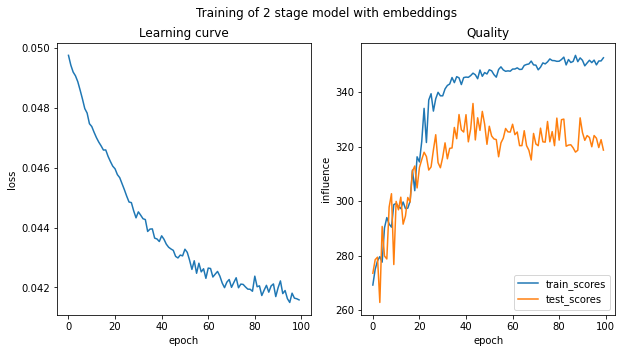

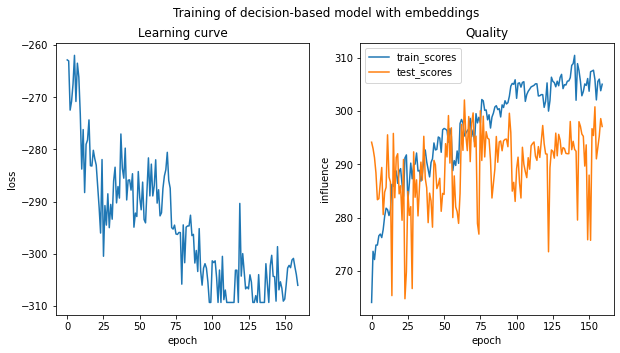

In [49]:
loss_df_emb = [-262.8118591308594, -263.0079040527344, -272.4454650878906, -270.74859619140625, -267.4384460449219, -261.939453125, -270.787841796875, -263.4472961425781, -266.10546875, -273.19647216796875, -283.7563781738281, -276.1786193847656, -288.262451171875, -279.0069274902344, -278.18560791015625, -274.32049560546875, -283.1082458496094, -283.1709289550781, -280.1507873535156, -281.76641845703125, -282.9951171875, -287.120361328125, -291.11474609375, -296.02801513671875, -281.9295654296875, -300.48199462890625, -290.7549743652344, -294.5001525878906, -288.49688720703125, -294.99871826171875, -290.5343017578125, -293.37225341796875, -286.04229736328125, -283.3963928222656, -290.2430725097656, -287.10552978515625, -289.31884765625, -277.0249328613281, -283.5754699707031, -285.5028381347656, -279.7359313964844, -289.6799621582031, -285.8968811035156, -285.8207092285156, -287.78924560546875, -284.6455383300781, -294.90496826171875, -292.19647216796875, -292.85400390625, -284.229248046875, -289.20172119140625, -291.56829833984375, -286.25531005859375, -293.4385070800781, -294.07501220703125, -287.6119079589844, -281.6089782714844, -288.9038391113281, -282.805419921875, -288.91204833984375, -286.960205078125, -281.9750061035156, -290.285888671875, -287.7227478027344, -292.7336730957031, -292.13525390625, -287.4762878417969, -285.07635498046875, -283.8757629394531, -280.5406494140625, -285.9441833496094, -287.4139709472656, -294.98846435546875, -295.27252197265625, -294.50543212890625, -296.2109375, -296.29583740234375, -295.9141540527344, -295.93597412109375, -305.83648681640625, -294.4609375, -301.7230529785156, -294.89630126953125, -294.6640625, -294.6640625, -292.6065673828125, -296.51812744140625, -296.2827453613281, -301.782470703125, -299.372314453125, -303.4048767089844, -295.17669677734375, -303.27044677734375, -306.0223083496094, -302.76177978515625, -301.90618896484375, -302.7581481933594, -305.41314697265625, -309.3423156738281, -309.3423156738281, -301.3603820800781, -301.69403076171875, -301.3603820800781, -304.55316162109375, -309.3423156738281, -303.1263732910156, -309.3423156738281, -300.4988098144531, -308.8047790527344, -306.96319580078125, -309.3423156738281, -309.3423156738281, -309.3423156738281, -309.3423156738281, -309.3423156738281, -309.3423156738281, -303.15496826171875, -303.15496826171875, -309.3423156738281, -290.34405517578125, -304.293701171875, -299.9748229980469, -303.4258728027344, -306.7314453125, -306.373779296875, -306.7314453125, -304.0389099121094, -305.44775390625, -309.3423156738281, -309.3423156738281, -308.036865234375, -309.3423156738281, -304.0056457519531, -309.3423156738281, -309.3423156738281, -309.3423156738281, -309.3423156738281, -301.910400390625, -305.8116760253906, -309.3423156738281, -302.29443359375, -300.2975769042969, -304.3345642089844, -304.39593505859375, -309.09259033203125, -298.6356506347656, -306.92034912109375, -305.3788757324219, -306.60321044921875, -309.09259033203125, -308.68731689453125, -305.90667724609375, -302.73382568359375, -302.2306823730469, -302.67218017578125, -301.19384765625, -300.89215087890625, -302.52716064453125, -304.0056457519531, -306.0589294433594]
loss_2s_emb = [0.049756620079278946, 0.04943124204874039, 0.04919959232211113, 0.04907245934009552, 0.04887562617659569, 0.04859468340873718, 0.048298995941877365, 0.047978006303310394, 0.047828998416662216, 0.0474722757935524, 0.047377899289131165, 0.047184690833091736, 0.047007445245981216, 0.04685795307159424, 0.046733178198337555, 0.04659287631511688, 0.046595510095357895, 0.04638063907623291, 0.046209853142499924, 0.0460539348423481, 0.045964762568473816, 0.04577065631747246, 0.04566934332251549, 0.04546823352575302, 0.04526754841208458, 0.04505041241645813, 0.04485558718442917, 0.04483605548739433, 0.04455972835421562, 0.04432724043726921, 0.044527098536491394, 0.04441605880856514, 0.04429694637656212, 0.04426915943622589, 0.043872181326150894, 0.043951015919446945, 0.043957192450761795, 0.04364880174398422, 0.043620821088552475, 0.04353552311658859, 0.043726637959480286, 0.043611589819192886, 0.043447095900774, 0.043343983590602875, 0.043286729604005814, 0.043240148574113846, 0.04303840547800064, 0.04298636317253113, 0.04308255389332771, 0.04305625706911087, 0.043277557939291, 0.043172433972358704, 0.04290982708334923, 0.042603109031915665, 0.04289179667830467, 0.042474180459976196, 0.04281088337302208, 0.04252152889966965, 0.04262460023164749, 0.04230543226003647, 0.04264785721898079, 0.04263319447636604, 0.042349282652139664, 0.04244548827409744, 0.04253559932112694, 0.0423797182738781, 0.042149707674980164, 0.04199383407831192, 0.04217784106731415, 0.042266666889190674, 0.04200427606701851, 0.04216689243912697, 0.042324431240558624, 0.0419900007545948, 0.04211224243044853, 0.042101677507162094, 0.04201657325029373, 0.04194395989179611, 0.04193978011608124, 0.041873037815093994, 0.042377449572086334, 0.04202369600534439, 0.04205387458205223, 0.041731055825948715, 0.041908711194992065, 0.04207131266593933, 0.04184277355670929, 0.04205033555626869, 0.04211849719285965, 0.041695497930049896, 0.0419917106628418, 0.04221896082162857, 0.04179602488875389, 0.04189731180667877, 0.041626736521720886, 0.041499413549900055, 0.04180915653705597, 0.04164331406354904, 0.041623178869485855, 0.04158473014831543]
train_scores_df_emb = [264.07714462280273, 273.67938232421875, 272.1374206542969, 274.8553161621094, 274.85930252075195, 276.595983505249, 276.92343521118164, 276.26366806030273, 277.7849998474121, 280.2400245666504, 281.7793197631836, 281.51030349731445, 280.40113067626953, 281.4834213256836, 286.2638931274414, 285.9014129638672, 288.68530654907227, 288.77072525024414, 286.44481658935547, 288.67569732666016, 289.2192726135254, 286.31419372558594, 284.0045280456543, 291.2280693054199, 291.794921875, 283.2051429748535, 286.34677505493164, 290.2531318664551, 287.2987937927246, 289.9256477355957, 290.0600776672363, 292.15246200561523, 288.7624969482422, 288.8821449279785, 286.8656768798828, 288.3081588745117, 291.0103950500488, 292.71765518188477, 290.4848175048828, 289.06328201293945, 287.6611557006836, 290.3750228881836, 291.06873321533203, 294.04063415527344, 292.72362518310547, 292.83289337158203, 295.16487884521484, 294.9701271057129, 292.2857437133789, 296.5135498046875, 296.7622833251953, 296.62825775146484, 296.40161895751953, 294.1808738708496, 296.7310256958008, 295.28662872314453, 288.8396873474121, 290.7191162109375, 289.8131446838379, 292.53479766845703, 290.20490646362305, 297.6912536621094, 298.4540214538574, 297.7763557434082, 295.3467826843262, 295.87282943725586, 296.32097244262695, 296.68014907836914, 298.66508865356445, 295.2181510925293, 296.4811592102051, 294.1860122680664, 299.54198837280273, 297.80865478515625, 298.8634910583496, 297.8235549926758, 302.1942672729492, 301.960018157959, 300.17004013061523, 300.2388000488281, 298.38586807250977, 299.3401527404785, 296.84051513671875, 298.89806747436523, 299.6436996459961, 300.7910041809082, 301.0373115539551, 300.3086853027344, 300.48425674438477, 298.9205207824707, 301.19097900390625, 300.6981773376465, 301.97220611572266, 301.3621368408203, 301.6013946533203, 302.8053398132324, 304.71067810058594, 305.2195510864258, 305.0594825744629, 305.9086380004883, 302.4239158630371, 305.2378578186035, 305.333438873291, 304.52252197265625, 305.40398025512695, 305.54545974731445, 301.8510551452637, 303.1299133300781, 303.7483825683594, 304.13941192626953, 304.5704154968262, 304.7031364440918, 304.85742950439453, 305.14869689941406, 305.14869689941406, 302.8673324584961, 302.9119567871094, 303.1177062988281, 303.1177062988281, 300.72560119628906, 301.84793853759766, 305.3231010437012, 300.01750564575195, 302.0037841796875, 306.39213943481445, 305.60803604125977, 305.38178634643555, 304.5899772644043, 305.63714599609375, 304.78514099121094, 306.3421401977539, 306.92545318603516, 304.2409973144531, 304.9838104248047, 304.92574310302734, 305.65454864501953, 305.69506072998047, 306.30366134643555, 308.6108627319336, 308.94250869750977, 310.49565505981445, 302.05914306640625, 308.9436492919922, 307.6527633666992, 305.6381950378418, 302.89978790283203, 303.6987190246582, 305.1219787597656, 304.8419990539551, 306.1462631225586, 303.7562141418457, 307.4146156311035, 307.54897689819336, 307.7074737548828, 305.9671630859375, 302.1224822998047, 305.59090423583984, 306.0374565124512, 303.84892654418945, 305.0716094970703]
train_scores_2s_emb = [269.2200698852539, 274.9747772216797, 278.08017349243164, 279.6367530822754, 277.6254463195801, 290.2075538635254, 293.98034286499023, 291.6207084655762, 290.47503662109375, 298.7552680969238, 299.1583061218262, 298.0206985473633, 297.27864837646484, 299.7141876220703, 297.2945327758789, 297.4380416870117, 299.9969139099121, 311.44409942626953, 303.86085510253906, 316.2932777404785, 314.4063415527344, 321.98117446899414, 334.0755920410156, 321.5423393249512, 337.12159729003906, 339.4498405456543, 333.07352447509766, 337.6074905395508, 339.96479415893555, 338.68154525756836, 338.6803092956543, 341.21181869506836, 342.4854736328125, 343.014591217041, 345.3985252380371, 343.5185775756836, 345.7137451171875, 345.2882652282715, 342.8121871948242, 345.3767547607422, 345.5598907470703, 345.46886825561523, 346.10302352905273, 347.0054702758789, 346.4099426269531, 344.9537811279297, 348.15979385375977, 345.8484878540039, 347.2235565185547, 346.6928825378418, 348.25106048583984, 347.85929107666016, 346.45565032958984, 345.52343368530273, 348.35826873779297, 349.3188934326172, 348.1916694641113, 347.68672943115234, 347.84679794311523, 347.7226219177246, 348.4974670410156, 348.5261001586914, 348.9512252807617, 348.3603172302246, 348.41960525512695, 349.84066009521484, 350.19274139404297, 350.3751220703125, 351.4335517883301, 350.03353118896484, 349.9477882385254, 348.2281799316406, 349.2178535461426, 350.7626838684082, 350.4053192138672, 351.1388130187988, 352.2249221801758, 351.6377258300781, 351.59250259399414, 351.3396224975586, 351.38915252685547, 352.01758193969727, 352.8872261047363, 350.0240669250488, 352.01165771484375, 350.915958404541, 351.31042861938477, 353.53816986083984, 351.21826553344727, 352.6026306152344, 351.7231025695801, 349.68681716918945, 350.74767303466797, 351.73857498168945, 350.8691940307617, 351.79570388793945, 350.0364112854004, 351.472957611084, 351.4922752380371, 352.6465301513672]
test_scores_2s_emb = [273.5550079345703, 278.526123046875, 279.43504333496094, 262.82550048828125, 290.73280334472656, 279.86602783203125, 278.79393005371094, 297.83912658691406, 302.7450866699219, 276.74835205078125, 299.93226623535156, 296.84254455566406, 301.4742431640625, 291.5633544921875, 294.5352783203125, 301.3560485839844, 299.68467712402344, 310.95556640625, 312.91233825683594, 304.8633117675781, 312.34535217285156, 315.2758026123047, 317.96624755859375, 316.39788818359375, 311.4309387207031, 312.5829315185547, 318.7881317138672, 324.4000244140625, 314.15235900878906, 312.2737731933594, 316.1302490234375, 321.4146728515625, 315.5686950683594, 319.40187072753906, 319.5404510498047, 327.06817626953125, 322.9496612548828, 331.81248474121094, 326.18263244628906, 325.38807678222656, 331.75657653808594, 321.78807067871094, 326.4947204589844, 335.8753967285156, 322.4887237548828, 330.61444091796875, 325.98789978027344, 332.95965576171875, 328.2752380371094, 320.88055419921875, 327.5157775878906, 323.9459686279297, 322.8533020019531, 322.61131286621094, 316.30592346191406, 321.4125671386719, 323.1193542480469, 326.69122314453125, 325.45677185058594, 325.3726501464844, 328.2450866699219, 324.4315490722656, 325.40159606933594, 320.3877410888672, 320.3877410888672, 325.8678436279297, 320.3877410888672, 318.70257568359375, 315.1328125, 324.86683654785156, 321.0085754394531, 320.3596496582031, 326.8143310546875, 321.7977752685547, 321.6711730957031, 329.26319885253906, 321.80247497558594, 325.549560546875, 320.38063049316406, 330.5074005126953, 322.41461181640625, 329.919921875, 330.1365966796875, 320.1767120361328, 320.6007385253906, 320.71710205078125, 319.57904052734375, 318.0163116455078, 318.6996307373047, 330.5931091308594, 325.22320556640625, 322.3417053222656, 324.0892639160156, 323.3811950683594, 319.9834289550781, 324.1024932861328, 323.11314392089844, 319.68896484375, 322.59185791015625, 318.7555694580078]
test_scores_df_emb = [294.17869567871094, 292.9980926513672, 291.2900390625, 288.4187774658203, 283.3710479736328, 283.5720977783203, 286.4540557861328, 289.4319763183594, 280.5750274658203, 284.78932189941406, 285.70562744140625, 295.567626953125, 287.62353515625, 286.68601989746094, 265.35975646972656, 295.83277893066406, 283.7502746582031, 291.31993103027344, 292.01849365234375, 284.4748077392578, 285.9969940185547, 279.51432037353516, 290.94691467285156, 264.7716827392578, 269.85687255859375, 284.93731689453125, 280.4285583496094, 282.0756607055664, 266.6831817626953, 292.3683624267578, 283.83741760253906, 287.110595703125, 280.3330078125, 285.6856231689453, 290.4446563720703, 287.04869079589844, 295.2902526855469, 287.4315490722656, 285.5912322998047, 279.06825256347656, 284.61376953125, 283.13609313964844, 278.2174987792969, 290.7761993408203, 289.9205780029297, 285.4657440185547, 286.21058654785156, 287.40667724609375, 281.19654846191406, 284.56524658203125, 284.3797149658203, 293.907470703125, 291.4111633300781, 299.1836700439453, 290.2624969482422, 296.88946533203125, 280.02056884765625, 287.84730529785156, 282.01649475097656, 281.1203079223633, 278.9307632446289, 284.5714416503906, 297.5435485839844, 292.6512451171875, 302.11375427246094, 295.43211364746094, 292.6046142578125, 298.9960174560547, 290.53163146972656, 297.69830322265625, 299.68409729003906, 293.308837890625, 295.3198547363281, 278.91961669921875, 276.9081115722656, 300.0885314941406, 290.74879455566406, 299.07122802734375, 291.4098205566406, 296.1578063964844, 294.93019104003906, 294.73854064941406, 290.8335418701172, 283.69602966308594, 286.40052795410156, 289.1478729248047, 295.2525329589844, 290.41351318359375, 294.23687744140625, 294.41773986816406, 292.5701446533203, 294.4276580810547, 294.7155303955078, 294.7575225830078, 293.33636474609375, 299.6209716796875, 295.9955596923828, 284.98838806152344, 286.6435852050781, 283.0568542480469, 289.2099304199219, 291.3736572265625, 286.5855407714844, 283.6965637207031, 293.2280578613281, 290.05267333984375, 288.6588439941406, 287.5229187011719, 291.268310546875, 289.1114196777344, 293.50852966308594, 293.9270782470703, 294.222412109375, 291.5527648925781, 290.77069091796875, 293.3509826660156, 291.31703186035156, 294.22190856933594, 297.3205261230469, 293.9014129638672, 291.9905090332031, 291.94854736328125, 273.5965576171875, 289.3760681152344, 292.7186584472656, 292.4886016845703, 291.18414306640625, 295.8889617919922, 291.62159729003906, 295.6519470214844, 294.5854034423828, 291.93182373046875, 293.1684875488281, 292.9839782714844, 292.0828094482422, 292.0237121582031, 292.0237121582031, 298.0744323730469, 292.77667236328125, 294.353759765625, 292.8267517089844, 292.4745178222656, 279.55621337890625, 298.034912109375, 297.16810607910156, 295.7073974609375, 295.2900085449219, 289.6935272216797, 293.6804504394531, 275.850341796875, 288.00144958496094, 275.7472229003906, 296.72572326660156, 295.43035888671875, 300.8296813964844, 291.05084228515625, 293.15740966796875, 295.3151550292969, 298.61810302734375, 297.127685546875]

print_training(loss_2s_emb, train_scores_2s_emb, test_scores_2s_emb, "Training of 2 stage model with embeddings")
print_training(loss_df_emb, train_scores_df_emb, test_scores_df_emb, "Training of decision-based model with embeddings")

#### Comparison of influence between models and random and greedy

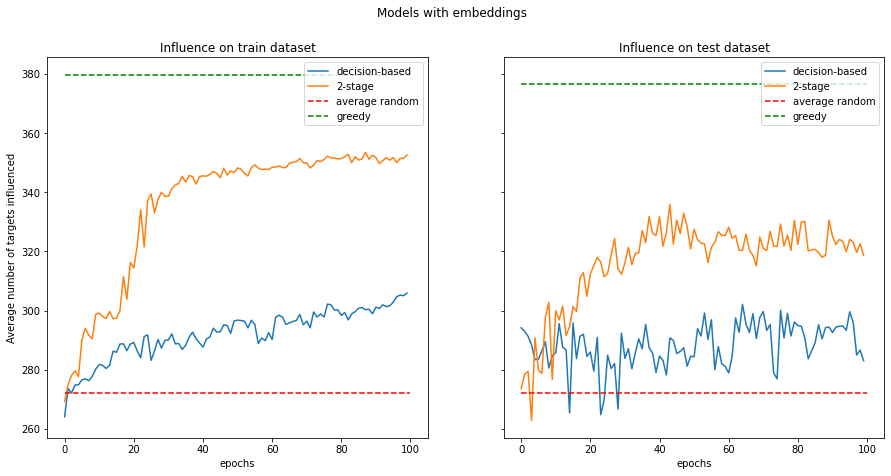

In [51]:
greedy_train = np.mean([greedy(k, Y_train[i,:,:].to(device),w)[0].item() for i in range(Y_train.shape[0])])
greedy_test = np.mean([greedy(k, Y_test[i,:,:].to(device),w)[0].item() for i in range(Y_test.shape[0])])

def compare_score_model(train_scores_df, test_scores_df, train_scores_2s, test_scores_2s, title="", rd_score_xtrain=0, rd_score_xtest=0):
    fig,ax = plt.subplots(1,2, figsize = (15,7), sharey=True)
    n = min(len(test_scores_2s),len(test_scores_df))

    ax[0].plot(train_scores_df[:n], label='decision-based')# ax = ax[0])
    ax[0].plot(train_scores_2s[:n], label='2-stage')# ax = ax[0])
    ax[0].hlines(y=rd_score_xtrain, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[0].hlines(y=greedy_train, xmin=0, xmax=n, linestyle='--', color='green', label='greedy')
    ax[0].legend(loc='upper right')
    ax[0].set_title("Influence on train dataset")
    ax[0].set_ylabel('Average number of targets influenced')
    ax[0].set_xlabel('epochs')

    ax[1].plot(test_scores_df[:n],label='decision-based')
    ax[1].plot(test_scores_2s[:n], label='2-stage')
    ax[1].hlines(y=rd_score_xtest, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[1].hlines(y=greedy_test, xmin=0, xmax=n, linestyle='--', color='green', label='greedy')
    ax[1].legend(loc='upper right')
    ax[1].set_title("Influence on test dataset")
    ax[1].set_xlabel('epochs')

    fig.suptitle(title)
    plt.show()

compare_score_model(train_scores_df_emb, test_scores_df_emb, train_scores_2s_emb, test_scores_2s_emb, "Models with embeddings", rd_score_xtrain, rd_score_xtest, )


end